In [16]:
import easyocr
import cv2
import random
import numpy as np
import imutils
import matplotlib.pyplot as plt

%matplotlib inline

In [20]:
detections = [{
    'bboxes': [
    [
        1857, 356, 1857, 362, 1855, 364, 1824, 364, 1824, 371, 1822, 373, 1808,
        373, 1808, 379, 1806, 381, 1783, 381, 1783, 388, 1781, 390, 1758, 390,
        1758, 396, 1756, 398, 1750, 398, 1750, 426, 1768, 426, 1768, 419, 1771,
        417, 1793, 417, 1793, 411, 1795, 409, 1810, 409, 1810, 402, 1812, 400,
        1835, 400, 1835, 394, 1837, 392, 1860, 392, 1860, 386, 1862, 383, 1884,
        383, 1884, 356
    ],
               [
                   1684, 466, 1684, 472, 1682, 474, 1659, 474, 1659, 480, 1657,
                   483, 1634, 483, 1634, 489, 1632, 491, 1609, 491, 1609, 527,
                   1628, 527, 1628, 521, 1630, 518, 1661, 518, 1661, 512, 1663,
                   510, 1694, 510, 1694, 504, 1696, 502, 1719, 502, 1719, 466
               ],
               [
                   1800, 561, 1800, 567, 1797, 569, 1775, 569, 1775, 588, 1851,
                   588, 1851, 582, 1853, 580, 1860, 580, 1860, 561
               ],
               [
                   1642, 577, 1642, 584, 1640, 586, 1617, 586, 1617, 592, 1615,
                   594, 1601, 594, 1601, 618, 1603, 618, 1605, 620, 1605, 639,
                   1632, 639, 1632, 637, 1634, 634, 1644, 634, 1644, 632, 1646,
                   630, 1677, 630, 1677, 624, 1680, 622, 1686, 622, 1686, 594,
                   1680, 594, 1677, 592, 1677, 577
               ],
               [
                   1576, 594, 1576, 601, 1574, 603, 1543, 603, 1543, 647, 1570,
                   647, 1570, 641, 1572, 639, 1603, 639, 1603, 620, 1597, 620,
                   1595, 618, 1595, 594
               ],
               [
                   1634, 637, 1634, 643, 1632, 645, 1593, 645, 1593, 681, 1686,
                   681, 1686, 662, 1680, 662, 1677, 660, 1677, 658, 1680, 656,
                   1686, 656, 1686, 637
               ],
               [
                   1800, 696, 1800, 702, 1797, 704, 1783, 704, 1783, 723, 1835,
                   723, 1835, 696
               ], [1882, 704, 1882, 727, 1917, 727, 1917, 704],
               [1882, 729, 1882, 748, 1917, 748, 1917, 729]],
    'scores': [
        0.9052858948707581, 0.925395667552948, 0.9141532182693481,
        0.9358830451965332, 0.9069939255714417, 0.9215288758277893,
        0.8235360980033875, 0.9075530767440796, 0.7763643264770508
    ]
}]


In [21]:
# read image 
image = cv2.imread('yeka.png')

In [14]:
# easyocr
reader = easyocr.Reader(['ru'])


# def draw(img, boxes):
#     for pts in boxes:
#         pts = np.array(pts).reshape((-1, 1, 2)).astype(np.int32)
#         ## (1) Crop the bounding rect
#         rect = cv2.boundingRect(pts)
#         x,y,w,h = rect
#         croped = img[y:y+h, x:x+w].copy()

#         ## (2) make mask
#         pts = pts - pts.min(axis=0)

#         mask = np.zeros(croped.shape[:2], np.uint8)
#         cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

#         ## (3) do bit-op
#         dst = cv2.bitwise_and(croped, croped, mask=mask)

#         # plt.figure(figsize=(10, 10))
#         plt.imshow(dst)
#         plt.show()

#         # text recognition
#         print("Unfiltered", reader.readtext(dst, detail=0))
        


# run the function
# draw(image, detections[0]['bboxes'])

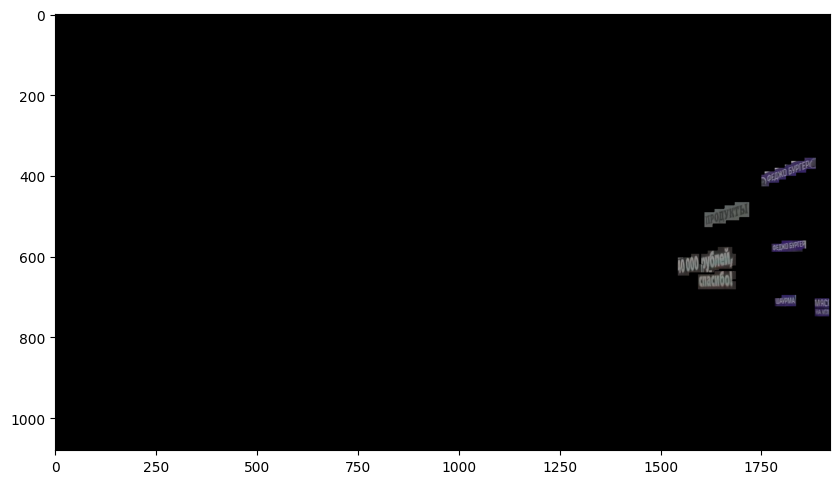

In [22]:
def draw(img, boxes):

    mask = np.full((img.shape[0], img.shape[1]), 0, dtype=np.uint8)

    for pts in boxes:
        mask  = cv2.fillPoly(mask, pts =[np.array(pts).reshape((-1, 1, 2)).astype(np.int32)], color=(255,255,255))

    # get first masked value (foreground)
    masked = cv2.bitwise_and(image, image, mask=mask)

    plt.figure(figsize=(10, 10))
    plt.imshow(masked)
    plt.show()

# run the function
draw(image, detections[0]['bboxes'])

## This functions plots the boxes on the relevant images

In [ ]:
import json

# clear the cell output
from IPython.display import clear_output

def draw_poly(json_file, save_path):
    with open(json_file) as f:
        data = json.load(f)

        # get the boxes for each image in img folder
        for i in data.keys():
            boxes = data[i]['FastResults'][0]["bboxes"]

            # image path is key of the dictionary
            image = cv2.imread(i)

            for pts in boxes:
                pts = np.array(pts).reshape((-1, 1, 2)).astype(np.int32)
                cv2.polylines(image, [pts], True, (0, 255, 0), 2)

            # plot the image
            plt.figure(figsize=(20, 10))
            plt.imshow(image)
            
            # save the image
            plt.savefig(save_path + i.split('/')[-1][:-4] + '.png')

            # clear cell output
            clear_output()

draw_poly('final_results.json', save_path='final_result/')